# Automatic scoring of x-ray images

Import dependencies

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# PIL to open & manipulate images
from PIL import Image, ImageOps, ImageChops

# for messages in loops
from IPython.display import clear_output

# to save arrays
import h5py

# for folder-timestamp
from datetime import datetime

# for train/test split
from sklearn.model_selection import train_test_split
# for one-hot encoding
from sklearn.preprocessing import LabelBinarizer
# for class weights
from sklearn.utils import class_weight
# for model evaluation
from sklearn.metrics import confusion_matrix, classification_report
# for efficient loops
import itertools

# keras
from tensorflow.contrib.keras.python.keras import backend as K
from tensorflow.contrib.keras.python.keras.utils.io_utils import HDF5Matrix
from tensorflow.contrib.keras.python.keras.models import Sequential
from tensorflow.contrib.keras.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Lambda, Activation
from tensorflow.contrib.keras.python.keras.layers.normalization import BatchNormalization
from tensorflow.contrib.keras.python.keras.preprocessing.image import ImageDataGenerator
from tensorflow.contrib.keras.python.keras import callbacks


Define image format & random seeds

In [2]:
# image format -> (rows, cols, channels)
K.set_image_data_format("channels_last")
# fix random seed for reproducibility
seed = 1
np.random.seed(seed)
tf.set_random_seed(seed)

Import numpy array and calculate class weights

In [3]:
with h5py.File('/data/joint_scoring/labels_train.h5', 'r') as hf:
    labels_train = hf['labels_train'][:]

# define class weights because of imbalance
weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                 classes=np.unique(labels_train), 
                                                 y=labels_train)

print(max(weights)/min(weights))

weights = dict(enumerate(weights))
print(weights)

112.229885057
{0: 0.2468182438891165, 1: 0.61240428271328862, 2: 7.3563288563288562, 3: 15.980990274093722, 4: 27.700383141762451, 5: 12.358632478632479}


Import data as HDF5 Matrix

In [4]:
img_train = HDF5Matrix('/data/joint_scoring/img_train.h5', 'img_train')
img_test = HDF5Matrix('/data/joint_scoring/img_test.h5', 'img_test')

labels_train = HDF5Matrix('/data/joint_scoring/labels_train_onehot.h5', 'labels_train_onehot')
labels_test = HDF5Matrix('/data/joint_scoring/labels_test_onehot.h5', 'labels_test_onehot')

In [5]:
train_datagen = ImageDataGenerator(
        rotation_range=25,
        shear_range=0.2,
        zoom_range=0.2)

In [6]:
num_classes = 6

## 2. Model

In [7]:
def conv_model():
    # create model
    model = Sequential()
    model.add(Lambda(lambda x: x / 255., input_shape=(150, 150, 1)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=32, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=64, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=128, kernel_size=(3, 3), padding="same", kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=256, kernel_initializer="he_normal"))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(rate=0.5))
    model.add(Dense(units=num_classes, activation="softmax",
                    kernel_initializer="he_normal"))

    # Compile model
    model.compile(optimizer="adam", loss="categorical_crossentropy",
                  metrics=["accuracy"])

    return model

In [8]:
# build the model
model = conv_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 150, 150, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 150, 150, 32)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 150, 150, 32)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 150, 150, 32)      9248      
_________________________________________________________________
batch_normalization_2 (Batch (None, 150, 150, 32)      128       
_________________________________________________________________
activation_2 (Activation)    (None, 150, 150, 32)      0         
__________

In [9]:
# create log directory
now = datetime.now
new_folder = '{}'.format(now().strftime('%Y%m%d_%H%M%S'))

In [10]:
print(new_folder)

20171026_154934


In [11]:
desc = "model with data generator and class weights. Division by 255 moved from generator to first (lambda) layer of the model"

with open("/data/joint_scoring/readme.txt", "a") as myfile:
    myfile.write("\n" + new_folder + "    " + desc)

In [12]:
# tensorboard callback
tb_callback = callbacks.TensorBoard(log_dir="/data/joint_scoring/tensorboard/" + new_folder,
                                    histogram_freq=0, write_graph=True,
                                    write_images=True)

In [13]:
model.fit_generator(generator=train_datagen.flow(img_train, labels_train, batch_size=32),
                    steps_per_epoch=len(img_train) / 32, 
                    epochs=20, verbose = 2, callbacks=[tb_callback], 
                    validation_data=(img_test, labels_test),
                    class_weight=weights)

Epoch 1/20
217s - loss: 1.9698 - acc: 0.1816 - val_loss: 1.3670 - val_acc: 0.3773
Epoch 2/20
208s - loss: 1.6896 - acc: 0.3716 - val_loss: 1.0308 - val_acc: 0.6032
Epoch 3/20
208s - loss: 1.5999 - acc: 0.4589 - val_loss: 0.8780 - val_acc: 0.6441
Epoch 4/20
208s - loss: 1.5680 - acc: 0.4885 - val_loss: 0.8112 - val_acc: 0.6647
Epoch 5/20
207s - loss: 1.5407 - acc: 0.5081 - val_loss: 1.0107 - val_acc: 0.6112
Epoch 6/20
208s - loss: 1.4940 - acc: 0.5099 - val_loss: 1.0467 - val_acc: 0.5951
Epoch 7/20
208s - loss: 1.4735 - acc: 0.5259 - val_loss: 0.9823 - val_acc: 0.6119
Epoch 8/20
207s - loss: 1.4474 - acc: 0.5347 - val_loss: 0.8749 - val_acc: 0.6518
Epoch 9/20
208s - loss: 1.4343 - acc: 0.5388 - val_loss: 1.0671 - val_acc: 0.5654
Epoch 10/20
208s - loss: 1.4127 - acc: 0.5541 - val_loss: 0.7858 - val_acc: 0.6807
Epoch 11/20
207s - loss: 1.3909 - acc: 0.5599 - val_loss: 0.8495 - val_acc: 0.6674
Epoch 12/20
208s - loss: 1.3866 - acc: 0.5647 - val_loss: 0.8912 - val_acc: 0.6294
Epoch 13/20
2

KeyboardInterrupt: 

In [14]:
# Final evaluation of the model
scores = model.evaluate(img_test, labels_test, verbose=0)
print("Error: %.2f%%" % (100 - scores[1] * 100))

Error: 32.00%


In [15]:
# Save the model
model.save("/data/joint_scoring/models/" + new_folder + ".h5")

In [16]:
from sklearn.metrics import confusion_matrix, classification_report
pred = model.predict_classes(img_test)
p = model.predict_proba(img_test)

print(classification_report(np.argmax(labels_test, axis=1), pred))
cnf_matrix = confusion_matrix(np.argmax(labels_test, axis=1), pred)
print(cnf_matrix)

19611/19611 [==============================] - 14s    
             precision    recall  f1-score   support

          0       0.75      0.92      0.82     13286
          1       0.48      0.17      0.25      5369
          2       0.16      0.28      0.21       423
          3       0.11      0.07      0.09       177
          4       0.08      0.21      0.11        98
          5       0.35      0.43      0.39       258

avg / total       0.65      0.68      0.64     19611

[[12174   785   141    29    56   101]
 [ 3987   895   330    37    62    58]
 [  112   118   120    15    39    19]
 [   17    30    74    13    30    13]
 [    9     9    27    13    21    19]
 [   18    17    38     8    65   112]]


Confusion matrix, without normalization
[[12174   785   141    29    56   101]
 [ 3987   895   330    37    62    58]
 [  112   118   120    15    39    19]
 [   17    30    74    13    30    13]
 [    9     9    27    13    21    19]
 [   18    17    38     8    65   112]]
Normalized confusion matrix
[[ 0.91630288  0.05908475  0.01061267  0.00218275  0.00421496  0.00760199]
 [ 0.74259639  0.16669771  0.06146396  0.00689141  0.01154777  0.01080276]
 [ 0.26477541  0.27895981  0.28368794  0.03546099  0.09219858  0.04491726]
 [ 0.0960452   0.16949153  0.4180791   0.07344633  0.16949153  0.07344633]
 [ 0.09183673  0.09183673  0.2755102   0.13265306  0.21428571  0.19387755]
 [ 0.06976744  0.06589147  0.14728682  0.03100775  0.25193798  0.43410853]]


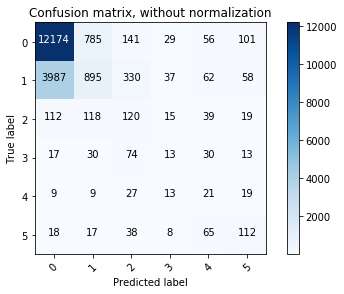

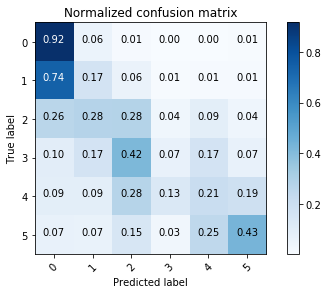

In [17]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=range(num_classes), normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [18]:
from nbconvert import HTMLExporter
import codecs
import nbformat
exporter = HTMLExporter()
output_notebook = nbformat.read('deepxray.ipynb', as_version=4)
output, resources = exporter.from_notebook_node(output_notebook)
codecs.open("/data/joint_scoring/notebooks/" + new_folder + ".html", 'w', encoding='utf-8').write(output)